In [1]:
from pathlib import Path

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import open3d as o3d 

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Read files

In [2]:
item_file_names = list(Path("data").glob("output_*[!_final].csv"))
item_file_names[:3]

[PosixPath('data/output_62.csv'),
 PosixPath('data/output_44.csv'),
 PosixPath('data/output_18.csv')]

In [3]:
floor = pd.read_csv("data/floor.csv", index_col=0)

items = []
for item_file_name in item_file_names:
    item = pd.read_csv(item_file_name, index_col=0)
    items.append(item)

In [4]:
floor.head()

,x,y,z
0,0.0,219.63515,9.462
1,0.0,203.81268,9.462
2,0.0,188.38454,9.462
3,0.0,172.77199,9.462
4,0.0,157.28883,9.462


In [5]:
floor.shape

(5098, 3)

In [6]:
items[0].head()

,x,y,z,conf
0,62.119286,229.76552,8.217,230.0
1,61.866330,213.80930,8.217,230.0
2,62.005833,197.95818,8.217,230.0
3,63.494423,181.94684,8.217,230.0
4,64.409960,166.35594,8.217,230.0


In [7]:
item.shape

(2415, 4)

# Make o3d point cloud

In [8]:
def convert_to_pcd(np_pcd):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd)
    return pcd 

In [9]:
items_pcds = []

for item in items: 
    item_pcd = convert_to_pcd(item.values[:,:-1])
    items_pcds.append(item_pcd)

In [10]:
floor_pcd = convert_to_pcd(floor.values)

In [11]:
o3d.visualization.draw_geometries([items_pcds[2]])

# Analysis on point distance
it seems like points are mostly capture at intervals of 10 (see the histogram below).

In [12]:
def compute_distance_to_self(pcd):
    # KDTree for finding the nearest neighbor
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)

    # To store the shortest distances
    distances = []

    # Loop through all points in the point cloud
    for i in range(np.asarray(pcd.points).shape[0]):
        # Find the 2 nearest neighbors (the first is the point itself)
        [k, idx, _] = pcd_tree.search_knn_vector_3d(pcd.points[i], 2)
        
        # Compute the distance to the nearest neighbor (not itself)
        if k >= 2:
            nn_distance = np.linalg.norm(np.asarray(pcd.points[i]) - np.asarray(pcd.points[idx[1]]))
            distances.append(nn_distance)
        else:
            # Handle the case where no neighbor is found
            distances.append(float('inf'))

    return distances

In [13]:
distances = []
for pcd in items_pcds: 
    distances += compute_distance_to_self(pcd)

In [14]:
len(distances)

105641

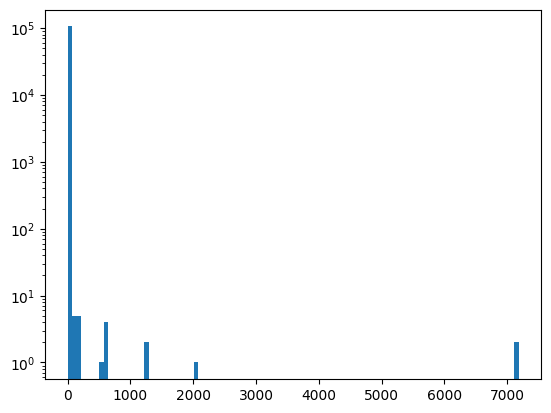

In [15]:
plt.hist(distances, bins=100)
plt.yscale("log");

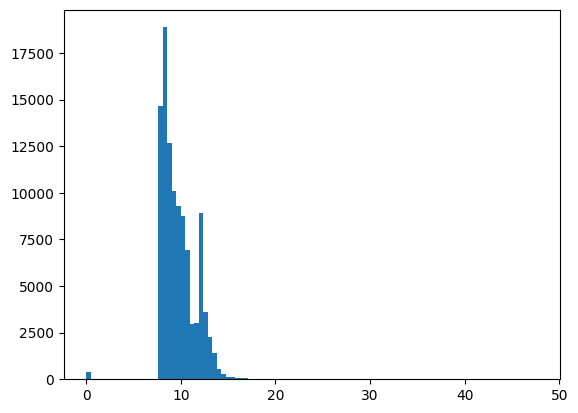

In [16]:
plt.hist([d for d in distances if d<50], bins=100);
# plt.yscale("log");

# Remove floor

In [17]:
def remove_floor(item_pcd, floor_pcd, threshold_distance):
    
    dists = item_pcd.compute_point_cloud_distance(floor_pcd)
    dists = np.asarray(dists)

    ind = np.where(dists > threshold_distance)[0]
    item_nofloor_pcd = item_pcd.select_by_index(ind)

    ind = np.where(dists <= threshold_distance)[0]
    item_floor_pcd = item_pcd.select_by_index(ind)

    return item_nofloor_pcd, item_floor_pcd

In [18]:
threshold_distance = 10

items_nofloor_pcds = []
items_floor_pcds = []

for item_pcd in items_pcds: 
    item_nofloor_pcd, item_floor_pcd = remove_floor(item_pcd, floor_pcd, threshold_distance)
    items_nofloor_pcds.append(item_nofloor_pcd)
    items_floor_pcds.append(item_floor_pcd)

In [19]:
idx = 5

o3d.visualization.draw_geometries([
    items_floor_pcds[idx].paint_uniform_color([1,.5,1]), 
    items_nofloor_pcds[idx].paint_uniform_color([0,1,1])
])

# Remove outliers

In [90]:
def remove_outliers(pcd, nb_neighbors=20, std_ratio=.5):
    cl, ind = pcd.remove_statistical_outlier(nb_neighbors=nb_neighbors, std_ratio=std_ratio)

    inlier_cloud = pcd.select_by_index(ind)

    return inlier_cloud

In [91]:
items_inlier_nofloor_pcds = []

for item_pcd in items_nofloor_pcds:
    item_inlier_pcd = remove_outliers(item_pcd)
    items_inlier_nofloor_pcds.append(item_inlier_pcd)

In [92]:
items_inlier_floor_pcds = []

for item_pcd in items_floor_pcds:
    item_inlier_pcd = remove_outliers(item_pcd)
    items_inlier_floor_pcds.append(item_inlier_pcd)

In [68]:
o3d.visualization.draw_geometries([
    items_inlier_nofloor_pcds[0].paint_uniform_color([0,1,1]), 
    items_inlier_floor_pcds[0].paint_uniform_color([1,.5,1])
])

In [69]:
def compute_bounding_box(pcd):
    # obb = pcd.get_oriented_bounding_box()
    obb = pcd.get_axis_aligned_bounding_box()
    return obb

In [70]:
bboxes_items = []

for item_pcd in items_inlier_nofloor_pcds:
    bbox = compute_bounding_box(item_pcd)
    bboxes_items.append(bbox)

In [71]:
bboxes_floors = []

for item_pcd in items_inlier_floor_pcds:
    bbox = compute_bounding_box(item_pcd)
    bboxes_floors.append(bbox)

In [72]:
idx = 10

o3d.visualization.draw_geometries([
    items_inlier_nofloor_pcds[idx], 
    bboxes_items[idx],
    items_inlier_floor_pcds[idx], 
    # bboxes_floors[idx]
])

In [93]:
def compute_bbox_from_point_cloud(item_np_pcd, floor_np_pcd, threshold_distance, nb_neighbors, std_ratio):
    item_pcd = convert_to_pcd(item_np_pcd.values[:,:-1])
    floor_pcd = convert_to_pcd(floor_np_pcd.values)

    item_nofloor_pcd, item_floor_pcd = remove_floor(item_pcd, floor_pcd, threshold_distance)

    item_nofloor_inlier_pcd = remove_outliers(item_nofloor_pcd, nb_neighbors, std_ratio)
    item_floor_inlier_pcd = remove_outliers(item_floor_pcd, nb_neighbors, std_ratio)

    bbox_item = compute_bounding_box(item_nofloor_inlier_pcd)
    bbox_floor = compute_bounding_box(item_floor_inlier_pcd)

    bbox_item.color = (1,0,0)
    bbox_floor.color = (0,1,0)

    # shift item to the floor
    bbox_item.min_bound = (
        bbox_floor.max_bound[0], 
        bbox_item.min_bound[1], 
        bbox_item.min_bound[2]
    )

    return bbox_item, bbox_floor, item_floor_inlier_pcd, item_nofloor_inlier_pcd

In [121]:
idx_item = 21

threshold_distance = 10
nb_neighbors=20
std_ratio=1

bbox_item, bbox_floor, item_floor_inlier_pcd, item_nofloor_inlier_pcd = compute_bbox_from_point_cloud(
    items[idx_item], 
    floor, 
    threshold_distance, 
    nb_neighbors, 
    std_ratio
)

axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=50, origin=bbox_floor.max_bound)

o3d.visualization.draw_geometries([
    item_nofloor_inlier_pcd.paint_uniform_color([0,1,1]),
    item_floor_inlier_pcd.paint_uniform_color([1,.5,1]), 
    bbox_item, 
    bbox_floor, 
    axis
])